# Установка зависимостей

Устанавливаем необходимые библиотеки

In [ ]:
!pip install torch torchvision ultralytics opencv-python numpy onnx onnxruntime-gpu roboflow seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

# Нарезаем видео на кадры

При просмотре видео можно заметить, что **4_1.MOV** является обрезанной частью **4.MOV**, поэтому это видео нарезать не будем, чтобы избежать лишних дубликатов. Также будем брать **1** кадр в секунду, чтобы также не плодить одинаковые кадры в выборке.

In [ ]:
import cv2
import os

video_paths = ["1.MOV", "2_1.MOV", "3_1.MOV", "3_2.MOV", "4.MOV"]
output_dirs = ["frames_1", "frames_2_1", "frames_3_1", "frames_3_2", "frames_4"]
for video_path, output_dir in zip(video_paths, output_dirs):
  os.makedirs(output_dir, exist_ok=True)

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frame_count = 0

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    if frame_count % round(fps) == 0:
      filename = os.path.join(output_dir, f"output_{frame_count:04d}.png")
      cv2.imwrite(filename, frame.transpose(1, 0, 2))
    frame_count += 1

  cap.release()

Копируем все кадры в одну папку и скачиваем архив для дальнейшей разметки

In [ ]:
import shutil
from pathlib import Path

dst_dir = 'images'
src_dirs = ['frames_1', 'frames_2_1', 'frames_3_1', 'frames_3_2', 'frames_4']
for src in src_dirs:
  paths = Path(src)
  img_paths = list(paths.glob("*.*"))
  for img in img_paths:
    dst_path = Path(dst_dir) / img.with_stem(str(img.stem) + '_' + str(img.parent).name).name
    shutil.copy(img, dst_path)

In [ ]:
import shutil
from google.colab import files

shutil.make_archive(dst_dir, 'zip', dst_dir)
files.download(f'{dst_dir}.zip')

# Разметка датасета

Перед основаной разметкой, я вручную просмотрела ещё раз кадры и удалила дубликаты. Таким образом у меня получился набор из **67** кадров.

Для дальнейшей разметки я использовала **Roboflow**.

Я выделила **7 классов**: *borsch, caesar salad, chicken, greek salad, meat, pumpkin soup, tea*

Далее я поделила датасет на *train/val/test* в соотношении *30/23/14*, так как в дальнейшем я хочу учеличить обучающую часть датасета с помощью аугментаций.

Также я добавила **Resize** до 480×640 в качестве препроцессинга. На большом разрешении нам обучаться не нужно, так как объектов на кадрах немного и они не маленькие.

Из аугментаций были использованы следующие: **HorizontalFlip, 90° Rotate, Crop, Rotation, Shear, Brightness, Exposure, Blur**

Таким образом я увеличила размер датасета до **127** кадров: *train/val/test - 90/23/14*

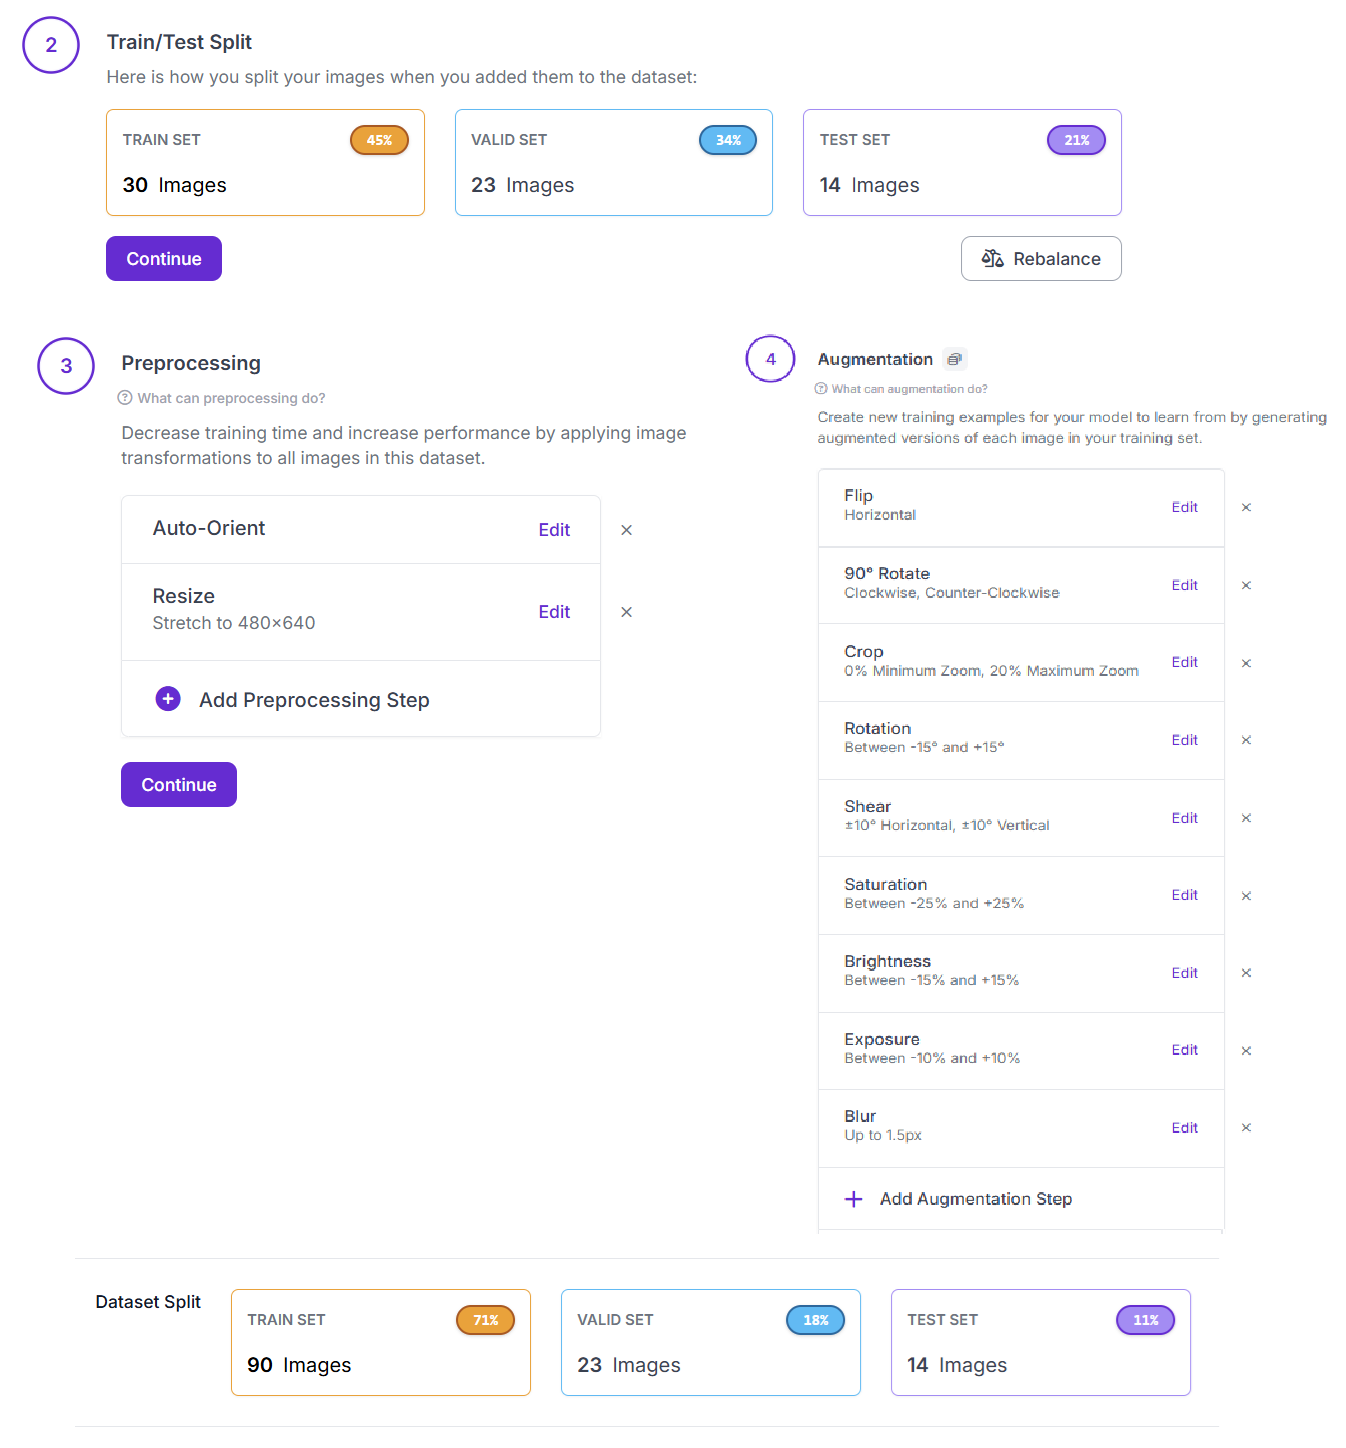

# Скачиваем датасет

Скачиваем созданный датасет с roboflow. Или скачиваем .zip архив (см. README)

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="ROBOFLOW_API_KEY_HERE")
# project = rf.workspace("WORKSPASE_NAME_HERE").project("PROJECT_NAME_HERE")
# version = project.version(3)
# dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dish-detection-3 in yolov11:: 100%|██████████| 266/266 [00:00<00:00, 2889.19it/s]


# Обучение

Напишем функцию для обучения.

**imgsz** выбран именно такой, так как в нашей выборке нет очень мелких блюд, соответственно мы не нуждаемся в очень большом входном разрешении картинки.

**batch** выбран таким, так как в видеопамять Google Colab 15GB помещается максимум **batch=128**. Кроме того, нет смысла в большем батче, так как в обучающей выборке всего 90 картинок:)

**epoch** - стандартное количество эпох для обучения YOLO, для тестирования мы потом берём лучший чекпоинт из всех

**patience** выбран равным количеству эпох, чтобы сравнить процесс обучения без early stopping

**optimizer** выбран *AdamW* так как у него хорошая сходимость

В рамках задания я решила подобрать **learning rate** из множества [0.01, 0.001].

**lrf, warmup_epochs, cos_lr** я зафиксировала, чтобы сравнить значения *learning rate* без его трансформации (под капотом значение параметра *lr0* не является финальным значением learning rate, а трансформируется в зависимости от других передаваемых параметров)

In [ ]:
from ultralytics import YOLO
import torch

def training(name, lr):
  model = YOLO("yolo11n.pt")

  results = model.train(
    data="dish-detection-3/data.yaml",
    batch=128,
    epochs=300,
    imgsz=(480, 640),
    device=0,
    lr0=lr,
    optimizer='AdamW',
    lrf=1.0,
    patience=300,
    warmup_epochs=0,
    cos_lr=False,
    name=name
  )

  path = model.export(format="onnx")
  return model

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model_01 = training(name='train_lr01', lr=0.01)

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.4MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dish-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(480, 640), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=1.0, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_lr01, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=300, perspective=0.0, plots=True, pose=12.0, p

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    432037  ultralytics.nn.modules.head.Detect           [7, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,591,205 parameters, 2,591,189 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 930.8±442.6 MB/s, size: 42.0 KB)


train: Scanning /content/dish-detection-3/train/labels... 90 images, 3 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 2511.84it/s]

train: New cache created: /content/dish-detection-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 709.8±625.1 MB/s, size: 54.3 KB)


val: Scanning /content/dish-detection-3/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 999.54it/s]

val: New cache created: /content/dish-detection-3/valid/labels.cache


Plotting labels to runs/detect/train_lr01/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train_lr01
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      11.1G      1.427      3.796      1.396        686        640: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         23         97    0.00427      0.385     0.0097    0.00609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/300      11.1G      1.472      3.766      1.459        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         23         97    0.00401      0.385    0.00935     0.0058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      11.2G      1.432      3.761      1.432        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         23         97    0.00407      0.403    0.00866    0.00546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      11.2G      1.364      3.786      1.379        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97    0.00424      0.403     0.0099    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      11.2G      1.449      3.775      1.445        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         97     0.0044      0.403     0.0107    0.00647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.1G      1.389        3.8      1.426        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         23         97    0.00466      0.403     0.0119    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      11.2G      1.395      3.766      1.432        610        640: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      11.1G      3.297       5.22      3.041        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      11.2G      3.323      5.108      3.033        575        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      11.2G      3.314      4.916      3.033        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      11.2G      3.421      5.099      3.131        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      11.2G       3.01      4.446      2.829        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      11.2G       2.96      4.441      2.815        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      11.2G      2.913      4.406       2.71        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.3G       2.91      4.224      2.702        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.2G      2.793      4.245      2.607        604        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.3G      2.785      4.073      2.595        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      11.2G      2.745      3.932      2.513        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      11.2G      2.667      3.745       2.47        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      11.2G      2.591      3.558      2.455        697        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      11.2G      2.605       3.54      2.494        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      11.3G      2.502      3.383      2.438        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      11.2G      2.447      3.269       2.41        655        640: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      11.2G      2.393      3.189      2.369        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      11.2G      2.315      3.126       2.33        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      11.2G      2.298      3.067      2.314        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      11.2G      2.215      2.971      2.285        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      11.2G      2.204      2.959      2.285        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      11.2G      2.213      2.855      2.273        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      11.2G      2.133      2.796      2.215        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      11.2G      2.106      2.786      2.195        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      11.2G      2.132      2.695      2.208        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      11.2G       2.05      2.636      2.148        742        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      11.2G       2.03      2.616      2.111        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300        11G      1.947      2.534      2.045        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      11.2G      1.945      2.555      2.038        719        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300        11G      1.834      2.345      1.953        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300        11G      1.916      2.434       1.99        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      11.2G       1.81      2.383      1.937        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      11.2G      1.834      2.283      1.944        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300        11G      1.839       2.26      1.927        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.1G       1.84      2.213      1.941        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300        11G      1.814      2.231      1.922        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.1G      1.755      2.202      1.875        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300        11G      1.716      2.117      1.826        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      11.2G      1.759      2.206      1.855        602        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      11.2G      1.706      2.044      1.826        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      11.2G      1.682      2.007       1.82        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.2G      1.651      1.953      1.797        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300        11G      1.641      1.913       1.79        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      11.2G      1.615       1.86       1.73        694        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300        11G      1.577      1.818      1.687        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      11.2G      1.583      1.774      1.687        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300        11G      1.563      1.793      1.678        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      11.2G      1.554      1.814      1.659        660        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      11.2G      1.564      1.747       1.68        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      11.2G      1.502      1.703       1.63        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      11.1G       1.55      1.698      1.647        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      11.2G      1.495      1.635      1.615        731        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      11.2G      1.525      1.705       1.66        559        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300        11G      1.466      1.586      1.592        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      11.2G      1.403      1.484      1.544        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      11.2G      1.506       1.52      1.596        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.2G      1.449      1.535      1.573        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300        11G      1.472      1.618      1.602        609        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      11.2G      1.493      1.518      1.597        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300        11G      1.481      1.522       1.58        554        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      11.2G      1.466      1.498      1.574        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      11.2G      1.436      1.514      1.566        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      11.2G      1.418      1.451       1.56        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      11.2G      1.394      1.391      1.536        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      11.2G      1.416      1.421      1.553        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      11.1G      1.315      1.284      1.471        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      11.2G      1.404      1.403      1.529        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.2G      1.304      1.286      1.461        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      11.2G      1.386      1.313       1.48        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.2G       1.37      1.288      1.469        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300        11G      1.318      1.272      1.455        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      11.3G        1.3      1.298      1.471        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         23         97      0.143    0.00649   0.000175   7.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      11.2G      1.345      1.294      1.474        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         23         97      0.143    0.00649   0.000195   5.85e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.1G      1.291      1.204      1.438        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      11.2G      1.311      1.275      1.463        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      11.3G      1.268      1.183      1.424        718        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         23         97   0.000752    0.00649    0.00033   6.36e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      11.1G      1.272      1.169      1.391        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         23         97   0.000493    0.00649   0.000216   4.26e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.2G      1.264        1.2      1.438        585        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      11.2G      1.267      1.208      1.413        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      11.3G      1.233      1.192       1.39        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         23         97   0.000548      0.013   0.000305   5.94e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      11.2G      1.274      1.208      1.402        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         23         97      0.002     0.0831    0.00143    0.00022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300        11G      1.203      1.166      1.393        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         23         97     0.0016      0.149    0.00127   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      11.2G      1.255      1.212      1.407        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         23         97    0.00982      0.187    0.00657    0.00195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      11.2G      1.223      1.079      1.374        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         23         97      0.722    0.00649    0.00342    0.00152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300        11G      1.221      1.106      1.359        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97     0.0015      0.158    0.00136   0.000506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      11.2G       1.28      1.096      1.394        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         23         97    0.00108      0.136     0.0011   0.000464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.2G       1.19      1.086      1.376        580        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97   0.000775     0.0909   0.000653   0.000261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      11.2G      1.213      1.122      1.375        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         23         97   0.000391      0.039   0.000262   8.18e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300        11G       1.17      1.049      1.336        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      11.2G      1.188      1.121      1.354        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      11.2G      1.157      1.041       1.33        608        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.2G      1.159      1.016      1.323        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.2G      1.173      1.032      1.317        704        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      11.1G      1.185      1.052      1.326        716        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300        11G      1.232      1.148      1.389        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      11.2G      1.175      1.052      1.328        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.2G      1.185      1.045      1.349        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.1G      1.156      1.041       1.33        615        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         23         97          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      11.2G      1.195      1.091      1.344        676        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97    0.00563     0.0972     0.0195    0.00731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      11.2G      1.155      1.062      1.336        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         23         97      0.408      0.106      0.145     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.2G      1.205      1.077      1.325        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         23         97      0.454     0.0214     0.0327    0.00919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      11.1G      1.141      1.052      1.311        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         23         97      0.457     0.0286     0.0456    0.00855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      11.2G      1.204      1.092      1.338        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         97      0.299      0.112      0.126     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      11.2G      1.131      1.025      1.308        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97      0.538        0.5      0.423      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      11.2G      1.115     0.9824      1.317        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         23         97      0.661       0.58       0.44       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      11.2G       1.14      1.013      1.319        589        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.888      0.482      0.604      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.2G      1.134      1.002      1.297        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23         97      0.809      0.667      0.674      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      11.1G      1.131      1.003      1.296        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.889      0.609      0.729      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      11.1G      1.152      1.008      1.303        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         23         97      0.918       0.62      0.712      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      11.1G       1.16          1      1.324        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         23         97      0.695      0.517      0.462      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      11.2G      1.126     0.9968      1.319        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         23         97      0.689      0.371      0.379      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      11.3G      1.141      1.012      1.314        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97      0.565      0.603      0.606      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300        11G      1.094     0.9659      1.269        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         23         97      0.844      0.639      0.738      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      11.2G      1.096     0.9687      1.265        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         23         97      0.753      0.725      0.748      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      11.1G      1.081     0.9648      1.276        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97      0.845      0.773      0.806      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      11.2G      1.061     0.9343      1.255        634        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         23         97      0.892      0.812      0.871       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      11.1G      1.122      0.899      1.262        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         23         97       0.76      0.792      0.834      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      11.1G      1.053     0.9022      1.241        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         23         97      0.832      0.704      0.764      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      11.2G      1.107     0.8937      1.247        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.555      0.685      0.716      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      11.1G      1.049     0.8871      1.228        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.506      0.674      0.704      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      11.1G      1.097     0.9352      1.264        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         97      0.533      0.591        0.7      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      11.1G      1.053     0.9026      1.244        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97       0.56      0.642      0.719      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      11.2G      1.051     0.9177      1.246        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         23         97      0.572       0.67       0.72      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      11.2G      1.031      0.908      1.237        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         23         97      0.503       0.61      0.688      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300        11G      1.037     0.9361      1.234        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.795      0.537      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      11.2G     0.9864     0.8878      1.192        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97      0.918      0.521      0.651      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      11.2G      1.036     0.8669      1.212        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         97      0.867      0.722      0.761      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300        11G       1.07     0.8883      1.231        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         23         97      0.799      0.791       0.83      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      11.2G      1.043      0.878       1.22        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         23         97      0.713      0.817      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      11.1G       1.02     0.8741      1.215        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         23         97      0.702      0.843      0.859      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      11.2G      1.035     0.8394      1.199        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         23         97      0.716       0.73      0.839      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300        11G      1.024     0.8695      1.205        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97       0.81      0.729      0.801      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300        11G      1.029     0.8904      1.218        685        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         23         97      0.884      0.757      0.797      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300        11G      1.045     0.8807      1.243        646        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.897      0.764      0.815      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      11.2G      1.058     0.8637      1.255        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         23         97      0.984      0.654      0.754      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300        11G     0.9821     0.8426      1.189        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.952      0.649      0.711      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300        11G       1.03     0.8765      1.239        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         23         97      0.923      0.772      0.892      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300        11G      1.074      0.919      1.263        569        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         23         97      0.866      0.831      0.914      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      11.1G      1.015     0.8491       1.19        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         23         97      0.865      0.772      0.864      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300        11G      1.031     0.8523      1.184        709        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.862      0.637      0.754      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300        11G      1.023     0.8801      1.215        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         23         97      0.953      0.449      0.655      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300        11G      1.082     0.9015      1.261        601        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         23         97      0.862      0.651      0.706      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      11.1G      1.094     0.8997      1.236        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97      0.859      0.679      0.781      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300        11G      1.032     0.8391      1.224        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23         97      0.619      0.837      0.861      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300        11G      1.053     0.8604      1.255        591        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         23         97      0.817      0.851       0.92      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      11.2G      1.017     0.8528      1.221        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.851      0.872      0.933      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      11.2G      1.053     0.9005      1.237        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         23         97      0.816      0.853      0.923      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      11.2G     0.9864     0.8056      1.165        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         23         97      0.804      0.809      0.875      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      11.1G     0.9639     0.7929      1.172        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97      0.736      0.719      0.816      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      11.1G     0.9799     0.8191      1.189        579        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         23         97      0.681      0.723        0.8      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      11.2G     0.9974     0.8169       1.18        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         23         97      0.717      0.741       0.78      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      11.2G     0.9677     0.8216      1.178        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         23         97       0.96      0.671      0.801      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      11.2G     0.9846     0.8255      1.177        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23         97      0.805      0.853      0.914      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      11.2G     0.9855     0.8133      1.164        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         23         97      0.925      0.895       0.93       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      11.2G      1.019     0.8303      1.179        658        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97      0.879      0.867      0.908      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      11.2G     0.9642     0.8202      1.191        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.748      0.849      0.866      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      11.2G     0.9388     0.7921      1.164        630        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97      0.799      0.813      0.888      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      11.1G     0.9282     0.7617      1.165        594        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         23         97      0.761      0.857      0.911       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      11.2G     0.9716     0.7952      1.178        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         23         97      0.886       0.77      0.892       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      11.2G      1.019     0.8159      1.179        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23         97      0.892      0.851      0.928      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      11.2G     0.9816     0.8132      1.181        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         23         97      0.959      0.835      0.935      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      11.2G     0.9186     0.7834      1.162        552        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.887       0.87      0.927      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      11.2G      1.008     0.8111      1.202        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         23         97      0.946      0.863      0.947      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      11.1G      1.019     0.8309      1.212        642        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         23         97      0.935      0.893      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      11.2G     0.9524     0.7874       1.15        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         23         97      0.892      0.748       0.86      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      11.2G     0.9569     0.7976      1.185        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         23         97      0.922      0.836      0.907      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      11.2G     0.9846     0.7501      1.175        620        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         23         97       0.93      0.874      0.924       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300        11G     0.9652      0.774       1.18        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         23         97      0.855      0.885      0.934      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      11.2G     0.9281     0.7666      1.145        738        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         23         97      0.779      0.898      0.931      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      11.2G     0.9248     0.7434      1.142        750        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.841      0.608      0.838      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      11.1G     0.9655     0.7786       1.18        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         23         97      0.868      0.463      0.626      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      11.1G     0.9732     0.8247      1.188        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97      0.635      0.546      0.616      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      11.1G      1.002     0.8003      1.179        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         23         97       0.66      0.667      0.685      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      11.2G     0.9305     0.7827      1.157        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         23         97      0.846      0.726      0.833      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      11.2G     0.9165      0.746      1.146        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         23         97      0.919      0.657      0.807      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      11.2G     0.9555     0.7683      1.144        739        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         23         97      0.832      0.691      0.825      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      11.1G     0.9099     0.7566      1.149        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         97      0.844      0.831      0.825      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      11.2G      0.915     0.7325      1.149        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         23         97      0.929      0.838      0.874      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      11.1G     0.9327     0.7658      1.148        567        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         97      0.947      0.826      0.889      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      11.2G     0.9912     0.7776        1.2        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         23         97      0.865      0.874      0.946      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      11.2G     0.9802     0.7896      1.166        715        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         23         97       0.84      0.859       0.91      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      11.1G      0.978     0.7648      1.174        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         97      0.876      0.787      0.886       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      11.1G     0.9666     0.7631      1.179        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97       0.78      0.773      0.834      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      11.2G     0.9185     0.7607      1.152        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         23         97      0.878      0.695      0.801      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      11.2G       0.94     0.7404      1.141        723        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97      0.642      0.713      0.771      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300        11G     0.9226     0.7571      1.161        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.681      0.708      0.786      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      11.2G     0.9225     0.7473      1.133        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         23         97       0.68      0.698      0.783      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      11.2G     0.9029     0.7334      1.146        681        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         97      0.672      0.793      0.864      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      11.1G     0.8997     0.7267      1.143        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         23         97      0.891       0.82      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      11.2G      1.007     0.7534      1.151        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         23         97      0.818      0.893      0.925      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      11.2G     0.9015     0.7217      1.142        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         23         97      0.802      0.843      0.928      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300        11G     0.9197     0.7354       1.14        597        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         23         97      0.809      0.827      0.904      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      11.2G     0.8847     0.7125      1.113        702        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         23         97      0.904      0.892      0.919      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300        11G     0.8862     0.7166      1.121        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23         97      0.887      0.891      0.923      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      11.2G     0.8734     0.7175      1.118        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         23         97      0.885       0.92      0.921       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      11.2G     0.8758     0.6991       1.11        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         97       0.95      0.905      0.921       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      11.3G      0.884     0.6935      1.117        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23         97      0.942      0.852      0.896      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300        11G     0.8873     0.7037      1.117        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         23         97      0.766       0.71      0.739        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      11.2G      0.839     0.6955      1.093        687        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         23         97      0.737      0.743      0.771      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      11.2G     0.9114     0.7079      1.124        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         23         97      0.767      0.799      0.806      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      11.2G     0.9567     0.7409       1.18        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         23         97      0.902      0.856      0.891      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      11.2G     0.8718     0.6749      1.113        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         23         97      0.958      0.895      0.917       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      11.3G     0.8813     0.6994       1.13        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23         97       0.96      0.894      0.917      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300        11G     0.9003     0.7356      1.158        539        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         23         97      0.943      0.883      0.914      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      11.2G      1.002      0.717      1.131        688        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         23         97       0.95      0.864      0.907      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      11.3G     0.9265     0.7191       1.12        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97      0.937      0.863      0.909      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      11.1G      1.059      0.792      1.223        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         23         97      0.955      0.873      0.922      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300        11G       0.96      0.735      1.151        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         23         97      0.946      0.873       0.92       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300        11G     0.8985     0.6899      1.113        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


                   all         23         97      0.955      0.874      0.901      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      11.2G     0.9181     0.7321      1.129        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.955      0.849      0.884      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      11.2G     0.8954     0.7158      1.116        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         23         97      0.884      0.836      0.895      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      11.2G     0.8599     0.6601      1.088        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         97      0.949      0.816       0.91      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      11.2G     0.8128     0.6597      1.073        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         23         97      0.977      0.775      0.874      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300        11G     0.8571      0.698      1.104        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         23         97      0.908      0.813      0.878      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      11.1G     0.8792     0.7054       1.12        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.904      0.813      0.858      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      11.2G     0.8344     0.6751      1.111        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.909      0.753        0.9      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      11.2G     0.8411     0.6715      1.089        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         23         97      0.908      0.889      0.909      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      11.3G     0.9622     0.7303      1.198        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all         23         97      0.964      0.888      0.922       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300        11G     0.8505     0.6785      1.092        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         23         97      0.977      0.887      0.926      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      11.2G     0.8753      0.691      1.112        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         23         97      0.971      0.867      0.925      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300        11G     0.8437     0.6985      1.107        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23         97      0.935      0.786      0.892      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      11.2G     0.8431     0.6694      1.095        714        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.915      0.808      0.881      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      11.1G     0.8302      0.645      1.081        692        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         23         97      0.966      0.887      0.916      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      11.2G     0.8345     0.6742        1.1        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         97      0.963      0.903      0.927      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      11.2G     0.8442      0.671      1.075        695        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97      0.966      0.909      0.929      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300        11G      0.887     0.7013      1.128        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         23         97      0.982        0.9      0.936      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      11.2G     0.8553     0.6834      1.092        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.967      0.918       0.94      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      11.3G     0.8599     0.6812      1.106        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         23         97      0.974      0.917      0.934      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      11.1G     0.8446      0.668      1.098        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97      0.963        0.9      0.924      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      11.2G     0.8343     0.6513      1.091        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97      0.913      0.846      0.911      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      11.1G     0.8075     0.6526       1.08        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         23         97      0.963      0.751      0.833      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      11.2G     0.8947     0.6495      1.093        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         23         97      0.765      0.741      0.769      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300        11G     0.8276      0.647      1.094        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.911      0.692      0.802       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300        11G     0.8593     0.6515      1.095        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         23         97      0.843      0.813      0.824      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      11.2G     0.8454     0.6843      1.112        551        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         97      0.887      0.821      0.822      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300        11G     0.9423     0.6849      1.104        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         23         97      0.891      0.788      0.816      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      11.1G     0.8457     0.6621      1.104        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.918      0.755      0.814       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      11.2G       0.83     0.6326      1.086        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         23         97      0.673      0.698      0.711       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300        11G     0.8297     0.6509      1.105        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         23         97      0.818      0.732      0.782      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      11.2G     0.9144     0.6777      1.113        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         23         97      0.964      0.737      0.807      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      11.2G     0.8754     0.6688       1.12        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         23         97      0.945      0.756      0.836      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      11.2G     0.8137     0.6306      1.083        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         23         97      0.784      0.779      0.813      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      11.2G     0.8351     0.6771      1.096        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.955      0.773      0.799      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      11.3G     0.8388     0.6377      1.086        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         23         97      0.919      0.857      0.884      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      11.1G     0.8287     0.6402       1.09        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.915      0.903      0.937      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      11.2G     0.8582     0.6404      1.111        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.803      0.839      0.924      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      11.2G     0.8355     0.6499      1.074        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         23         97      0.873       0.66      0.788       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      11.2G     0.8404      0.665       1.11        590        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         23         97      0.835      0.652      0.676      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300        11G      0.877     0.6517      1.121        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         23         97      0.959      0.672      0.774       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      11.2G     0.8438      0.657      1.096        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23         97      0.946      0.788      0.874      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      11.2G      0.872     0.6954      1.091        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         23         97      0.958      0.848      0.904       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      11.1G     0.8405     0.6369      1.087        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         23         97      0.892      0.897      0.905      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      11.1G     0.8233     0.6175      1.064        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         23         97      0.875      0.846      0.898      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300        11G     0.8118     0.6093      1.061        643        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97      0.857      0.901      0.906      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      11.2G     0.8073     0.6374      1.079        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97      0.908      0.879      0.922      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300        11G     0.7806     0.6057      1.062        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

                   all         23         97      0.907      0.914      0.932      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      11.2G      0.756     0.6139      1.053        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         23         97      0.952      0.907      0.916      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      11.2G     0.7771      0.631      1.064        663        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         23         97      0.954      0.885      0.904      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      11.2G     0.7901     0.6423      1.079        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97      0.937      0.866      0.886      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      11.2G     0.7687     0.5945      1.033        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.842      0.848      0.846      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      11.2G     0.7861     0.6173      1.064        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         23         97      0.951      0.862      0.902      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      11.2G     0.7898     0.6103      1.048        734        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         23         97      0.933      0.888      0.924      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      11.2G     0.8137     0.6095      1.075        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         23         97      0.961       0.91      0.943      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      11.1G     0.7848     0.6111      1.076        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97      0.969      0.917      0.936      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      11.2G     0.8009      0.634      1.075        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         23         97      0.961      0.923      0.929      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300        11G     0.8417     0.6461      1.088        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         23         97       0.95       0.89      0.922       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      11.2G     0.7603     0.5926      1.045        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         23         97      0.906      0.904      0.919      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300        11G     0.8562     0.6503      1.088        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.941      0.906      0.921      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      11.2G     0.7869     0.6207      1.059        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         23         97      0.949      0.901      0.938       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      11.2G     0.7386     0.5985      1.037        700        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         23         97      0.967      0.878      0.937      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300        11G     0.7304     0.5867      1.045        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         23         97      0.976       0.87      0.923      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      11.2G      0.803     0.6193       1.09        596        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         23         97      0.936       0.86      0.924      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300        11G     0.7499     0.5808      1.052        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         23         97      0.937      0.818      0.891      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      11.1G     0.7988     0.6129      1.053        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.933      0.884      0.915      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      11.2G     0.7825     0.6223      1.064        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         23         97       0.97      0.889      0.933      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      11.2G     0.7713     0.5984      1.054        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97      0.958      0.903      0.943      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300        11G     0.7711     0.6168      1.054        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         23         97      0.982      0.906      0.933       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      11.2G     0.8137     0.5854       1.06        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         23         97      0.987      0.903      0.927       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      11.2G      0.762     0.5968      1.051        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.951       0.91      0.926       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300        11G     0.7264     0.5616      1.015        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         23         97      0.911      0.896      0.924      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300        11G     0.7724     0.6012      1.069        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         23         97      0.961      0.894      0.921      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      11.2G     0.7639      0.592       1.06        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.969      0.908      0.918      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      11.1G     0.8007     0.6317      1.063        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         23         97      0.956      0.906      0.913      0.771


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300        11G     0.8562     0.5854      1.084        340        640: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         23         97      0.955      0.898      0.909      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300        11G     0.7575     0.5389      1.039        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         23         97      0.933      0.899      0.911      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300        11G     0.7431     0.5221     0.9986        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         23         97      0.965      0.863      0.897      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300        11G     0.8344      0.565      1.067        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         23         97      0.966      0.858      0.899      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300        11G     0.7408     0.5424      1.015        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.957      0.868      0.876      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300        11G     0.8026     0.5321       1.06        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


                   all         23         97      0.731      0.697      0.776      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300        11G     0.7881     0.5359      1.072        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23         97      0.738      0.526      0.609      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300        11G     0.6618     0.5255      1.007        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97      0.708      0.556      0.604      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300        11G     0.7055     0.4837      1.004        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         23         97      0.815      0.665      0.783      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300        11G     0.6656     0.4856      1.004        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         23         97      0.757      0.854      0.902      0.715



300 epochs completed in 0.180 hours.
Optimizer stripped from runs/detect/train_lr01/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train_lr01/weights/best.pt, 5.5MB

Validating runs/detect/train_lr01/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


                   all         23         97      0.966      0.909      0.929      0.794
                borsch          8          8          1      0.893      0.995        0.8
          caesar salad          8          8      0.964          1      0.995      0.901
               chicken         22         22          1      0.842      0.873      0.771
           greek salad          8          8      0.958          1      0.995      0.895
                  meat         20         20      0.908          1      0.988      0.795
          pumpkin soup          8          8      0.939      0.625      0.661      0.479
                   tea         23         23       0.99          1      0.995      0.918
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train_lr01
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.30GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more

In [ ]:
model_001 = training(name='train_lr001', lr=0.001)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dish-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(480, 640), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=1.0, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_lr001, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=300, perspective=0.0, plots=True, pose=12.0,

train: Scanning /content/dish-detection-3/train/labels.cache... 90 images, 3 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 665.6±381.1 MB/s, size: 54.3 KB)


val: Scanning /content/dish-detection-3/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]


Plotting labels to runs/detect/train_lr001/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train_lr001
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      11.2G      1.427      3.796      1.396        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         23         97    0.00427      0.385     0.0097    0.00609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      11.2G      1.472      3.766      1.459        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         23         97    0.00401      0.385    0.00935     0.0058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      11.3G      1.432      3.761      1.432        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         23         97    0.00407      0.403    0.00866    0.00546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      11.2G      1.364      3.786      1.379        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23         97    0.00424      0.403     0.0099    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      11.2G      1.449      3.775      1.445        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         23         97     0.0044      0.403     0.0107    0.00647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.1G      1.389        3.8      1.426        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         23         97    0.00466      0.403     0.0119    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      11.2G      1.395      3.766      1.432        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97     0.0151      0.477      0.124     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      11.2G      1.645      3.987      1.805        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         23         97     0.0179      0.651       0.15     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      11.2G      1.744      3.525      1.651        575        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         23         97     0.0188      0.633      0.152     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      11.2G      1.706      3.566      1.652        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97     0.0144       0.63      0.173     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      11.2G      1.416      3.362      1.395        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         23         97      0.011      0.687      0.202       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      11.2G      1.323      2.981      1.316        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97    0.00972      0.694      0.271      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      11.3G      1.258      2.664      1.275        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         23         97    0.00906      0.647      0.312      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      11.3G      1.218      2.365      1.287        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         23         97     0.0104        0.6      0.213      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.3G      1.113      2.179      1.224        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97    0.00933      0.509      0.164     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.2G      1.041      1.886      1.181        604        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23         97     0.0079      0.467      0.138     0.0597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.3G       1.04      1.809      1.185        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         23         97    0.00582       0.42     0.0921     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      11.2G      1.007      1.725      1.162        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97    0.00687      0.476       0.12     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      11.2G     0.9671      1.479      1.136        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23         97    0.00949      0.491      0.118     0.0787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      11.2G     0.9382      1.456      1.113        697        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         23         97     0.0107      0.505     0.0977     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      11.2G     0.9252      1.428      1.114        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97    0.00678      0.311     0.0165    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      11.3G     0.8944      1.376      1.096        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97    0.00577      0.209     0.0049    0.00151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      11.2G     0.8958      1.356      1.093        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         23         97    0.00649      0.325     0.0232     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      11.2G     0.8687      1.286      1.069        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97     0.0041       0.23     0.0174     0.0093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      11.2G     0.8449      1.219      1.069        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         23         97    0.00268      0.158     0.0152    0.00863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      11.2G     0.8192      1.168      1.055        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         23         97    0.00171      0.101     0.0166    0.00746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      11.3G     0.8183      1.114       1.05        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97     0.0027      0.129     0.0225      0.012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      11.2G     0.8296      1.108      1.047        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         23         97    0.00277      0.135     0.0184     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      11.2G     0.7927      1.043      1.027        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97    0.00307       0.19     0.0223     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      11.2G     0.8046      1.021      1.041        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         23         97    0.00284      0.196     0.0246     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      11.2G     0.7942      1.013      1.028        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         23         97    0.00385      0.267     0.0193     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      11.2G     0.8578      1.009      1.055        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         97    0.00888      0.426       0.05     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      11.2G     0.8158     0.9816      1.053        742        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97     0.0152      0.512     0.0768     0.0404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      11.3G     0.7816     0.9538      1.041        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         23         97     0.0186      0.623      0.114     0.0704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300        11G     0.8233     0.9523      1.073        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97     0.0169      0.621      0.138     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      11.2G     0.7621     0.9364       1.02        719        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         23         97     0.0171      0.614      0.117     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300        11G     0.7604     0.8597     0.9955        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         23         97     0.0165       0.68      0.154      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300        11G     0.7336     0.8852      1.005        629        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         97     0.0169      0.707      0.176      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      11.2G     0.7168     0.8342     0.9938        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         23         97     0.0155      0.707      0.186      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      11.3G     0.7251     0.8284      1.006        645        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         23         97     0.0174      0.707      0.221      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300        11G     0.7227     0.8417      1.006        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         23         97     0.0152        0.7      0.239      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.2G     0.7073      0.828     0.9892        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         23         97     0.0152      0.707      0.265      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300        11G     0.7067     0.8268     0.9903        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         23         97     0.0145      0.714      0.269      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.2G     0.6619     0.8102     0.9671        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         23         97     0.0145      0.714      0.299      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300        11G     0.6537     0.7973     0.9798        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         23         97     0.0141      0.683      0.278       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      11.2G     0.6852     0.8075     0.9801        602        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97     0.0139      0.654       0.27      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      11.3G     0.7131     0.8149     0.9805        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         23         97     0.0144      0.672      0.316      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      11.2G     0.6936     0.7866     0.9661        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         97     0.0143      0.679      0.376      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.2G     0.6991     0.7561     0.9904        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97     0.0149      0.696      0.402      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300        11G     0.6864     0.7609     0.9916        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         23         97     0.0195      0.714      0.421      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      11.2G     0.7067     0.7525     0.9665        694        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         97      0.022      0.714      0.463      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300        11G     0.7494     0.7552     0.9797        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         23         97     0.0226      0.696      0.483      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      11.2G     0.6544     0.7277     0.9527        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         23         97     0.0142      0.607      0.399      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300        11G     0.7694     0.7548      1.019        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         23         97     0.0169      0.726      0.474      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      11.2G     0.8148     0.7448      1.035        660        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         23         97     0.0226      0.761      0.486      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      11.2G     0.7278     0.7372      1.005        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23         97     0.0271      0.755      0.497      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      11.3G     0.6151     0.6983     0.9433        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         23         97     0.0223      0.732       0.48      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      11.2G     0.6814     0.7158      0.953        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97     0.0181      0.714      0.467      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      11.2G     0.7316     0.7158     0.9764        731        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97     0.0155      0.714      0.527      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      11.2G     0.6345     0.7262     0.9729        559        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97     0.0146      0.701      0.553      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300        11G     0.5725     0.6848     0.9437        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         23         97     0.0135      0.701      0.553      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      11.2G     0.5622     0.6496     0.9246        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97      0.014      0.708      0.539      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      11.3G     0.5903     0.6425     0.9177        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         23         97       0.78      0.448      0.556       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.3G      0.577     0.6541     0.9233        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97       0.85      0.413      0.531      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300        11G     0.5741     0.6568     0.9366        609        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         23         97      0.992      0.266      0.626      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      11.2G      0.565     0.6374     0.9211        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.998      0.243       0.64      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300        11G     0.5771     0.6599     0.9162        554        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         23         97      0.935      0.262      0.707      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      11.2G     0.5808     0.6313     0.9364        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         23         97      0.564      0.722      0.674      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      11.2G      0.582     0.6286     0.9276        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         23         97      0.891      0.524      0.649      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      11.3G     0.5472     0.6258     0.9161        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         23         97      0.857      0.148      0.652      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      11.2G     0.5675     0.6166     0.9222        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         23         97      0.999      0.164      0.711       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      11.2G     0.5584     0.6289     0.9298        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         97      0.993      0.248      0.707      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      11.2G       0.55      0.606     0.9171        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         97      0.993      0.249        0.7      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      11.2G     0.5412     0.6146     0.9173        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         23         97      0.846      0.248      0.721      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.2G      0.545     0.6264     0.9203        639        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97       0.87      0.258      0.773      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      11.2G     0.5682     0.6038     0.9108        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         23         97      0.912      0.235      0.795      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.2G     0.5516     0.5906     0.9101        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.965      0.322      0.797        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300        11G     0.5789     0.5983     0.9332        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         23         97      0.975      0.435      0.829      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      11.3G     0.5532     0.5945     0.9386        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         23         97      0.992      0.448      0.848      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      11.2G     0.5756     0.6083     0.9184        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97      0.995      0.438      0.852      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.2G     0.6121     0.6155       0.93        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         23         97      0.996      0.368      0.861      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      11.2G     0.5469     0.6183     0.9144        605        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97      0.987       0.36      0.867      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      11.3G     0.5245     0.5913     0.8965        718        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         23         97      0.955      0.391      0.858      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      11.2G     0.5155     0.5634     0.9019        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         23         97      0.952       0.57      0.869      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.3G     0.5555     0.5832     0.9389        585        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97      0.933      0.571      0.868      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      11.2G     0.5069     0.5746     0.9113        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         23         97      0.921       0.58      0.897       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      11.4G     0.5205     0.5717     0.9013        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.899      0.606      0.901       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      11.2G     0.5558      0.566       0.91        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         23         97      0.927      0.644      0.913      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300        11G     0.5497     0.5758     0.9213        626        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.949      0.693       0.92      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      11.2G     0.5414     0.5796     0.9005        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.939      0.725      0.929      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      11.2G     0.5066     0.5505     0.8939        637        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97      0.942      0.839      0.934      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300        11G     0.5949     0.5642     0.9179        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23         97      0.932      0.851      0.951       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      11.2G     0.5807      0.568     0.9149        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         23         97      0.938      0.844      0.954      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.2G     0.5101     0.5392     0.9117        580        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         97       0.95      0.837      0.955      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      11.3G     0.5133     0.5461     0.8938        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         23         97      0.963      0.835       0.94      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300        11G      0.528     0.5395     0.8975        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         23         97      0.968      0.828      0.935      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      11.2G     0.4945     0.5353     0.9054        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         23         97      0.956      0.827       0.93      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      11.2G     0.4726     0.5248     0.8984        608        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         23         97      0.961      0.813      0.917      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.3G     0.5208     0.5296     0.9018        686        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         23         97      0.958      0.809      0.916      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.2G     0.5339     0.5396     0.9082        704        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.953      0.813      0.921      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      11.2G      0.509     0.5262     0.8884        716        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         23         97      0.933      0.791      0.929      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300        11G     0.6334     0.5483     0.9652        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.918      0.764      0.928      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      11.3G     0.6001     0.5509     0.9459        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         23         97      0.934      0.756       0.93      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.2G     0.5215     0.5235      0.916        674        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.937      0.767      0.955      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.2G     0.5494     0.5357     0.9209        615        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         97      0.934       0.82      0.954      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      11.2G     0.6438     0.5556     0.9428        676        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97      0.948      0.829      0.953      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      11.2G     0.6303     0.5697     0.9528        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         97      0.948      0.828      0.937      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.2G     0.5449     0.5383     0.9223        631        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         23         97      0.941      0.745      0.929      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      11.2G     0.5646     0.5566     0.9193        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         23         97      0.945      0.709      0.924      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      11.2G     0.6519     0.5707     0.9642        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         23         97      0.938      0.774      0.922       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      11.2G     0.6155     0.5424     0.9336        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.914       0.84      0.921      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      11.2G     0.5785      0.538     0.9439        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         23         97      0.924      0.873       0.93      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      11.2G     0.5511     0.5306     0.9269        589        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97      0.933      0.875      0.945      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.2G     0.6357     0.5538     0.9364        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         97      0.938      0.881       0.98      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      11.2G     0.6053     0.5437     0.9172        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         23         97      0.936       0.89      0.964       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      11.2G     0.5739     0.5393     0.9272        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         23         97      0.932      0.899      0.962       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      11.2G     0.5139     0.5181      0.909        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         23         97      0.932      0.909      0.961      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      11.2G     0.5045     0.5267     0.9069        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


                   all         23         97      0.932      0.914      0.972      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      11.3G     0.5289     0.5235      0.904        666        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         23         97       0.93      0.917      0.963      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300        11G     0.5185     0.5105     0.8973        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         97       0.93       0.92      0.972      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      11.2G      0.505      0.512     0.8899        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         23         97      0.929      0.928       0.96      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      11.2G     0.4917     0.5042     0.8933        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.928      0.936      0.962      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      11.3G     0.4999     0.4885     0.9036        634        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


                   all         23         97      0.922       0.93      0.965      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      11.2G     0.4682     0.4636     0.8816        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.922      0.918      0.969      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      11.2G     0.4595     0.4734     0.8982        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all         23         97      0.912      0.912      0.971       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      11.2G     0.4694     0.4772      0.885        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         23         97      0.917      0.909      0.973      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      11.2G     0.4839     0.4664     0.8812        675        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         97       0.92      0.917      0.982      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      11.2G     0.4518     0.4594     0.8877        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         23         97      0.922      0.911      0.979      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      11.2G     0.4502     0.4598     0.8759        721        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         23         97       0.96      0.885      0.978      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      11.2G     0.4919     0.4884     0.9031        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         23         97      0.954       0.89      0.978      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      11.2G     0.4684     0.4834     0.8942        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97      0.925      0.902      0.979       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300        11G     0.4652     0.4781     0.9005        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         23         97      0.937      0.885      0.978      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      11.2G     0.4564     0.4713     0.8776        698        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         23         97      0.909      0.883      0.967      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      11.2G     0.4751     0.4776      0.883        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         23         97      0.877      0.887      0.959      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300        11G     0.5262     0.4979     0.9025        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         23         97      0.914      0.864      0.942      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      11.3G     0.4903     0.4811     0.8924        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         23         97      0.929      0.867      0.942      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      11.2G     0.4468     0.4765     0.8832        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         23         97      0.929      0.852      0.942      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      11.2G     0.4504     0.4575     0.8675        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         23         97      0.934      0.878      0.942      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300        11G     0.4706     0.4624     0.8886        593        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         23         97      0.947       0.88      0.945      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300        11G     0.4609     0.4673     0.8818        685        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         23         97       0.95      0.885      0.959      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300        11G     0.4559     0.4511     0.8884        646        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.966      0.894       0.96      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      11.3G     0.5081     0.4744     0.9099        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         23         97      0.972      0.893      0.963      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300        11G     0.4573      0.449     0.8747        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97      0.966      0.892      0.964      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300        11G     0.4694     0.4509     0.8939        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         97      0.959      0.891      0.965      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300        11G     0.4925     0.4829     0.8983        569        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         23         97      0.941      0.896      0.968      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      11.2G     0.4521      0.449     0.8768        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         23         97      0.903      0.922      0.968      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300        11G     0.4364     0.4571     0.8661        709        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         23         97      0.909      0.925      0.967      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300        11G     0.5027     0.4623     0.9109        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.911      0.926      0.956      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300        11G     0.5603     0.4798       0.93        601        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         23         97      0.906      0.913      0.954      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      11.2G     0.4796      0.468     0.8873        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         23         97      0.898      0.917      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300        11G     0.4496      0.452     0.8815        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         23         97      0.912      0.905      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300        11G     0.5275     0.4829     0.9077        591        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97      0.939      0.899      0.967      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      11.3G     0.5254     0.4795     0.8995        570        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         23         97      0.934      0.908      0.965      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      11.2G      0.506     0.4903     0.9141        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         23         97       0.93      0.915      0.967      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      11.2G     0.4963     0.4688     0.8828        683        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.926      0.916      0.958      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      11.2G     0.5405     0.4663     0.9067        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         23         97      0.909       0.92      0.959      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      11.2G     0.5341     0.4618     0.9015        579        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.964      0.882      0.972      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      11.2G     0.4405     0.4446     0.8746        669        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         23         97      0.938      0.895      0.972       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      11.3G     0.4888     0.4577     0.8891        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.961      0.876      0.965       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      11.2G     0.5884     0.4703     0.9199        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         23         97      0.955      0.882      0.967      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      11.3G       0.54     0.4588     0.8942        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         23         97      0.957       0.88      0.969       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      11.3G     0.4909     0.4463      0.893        658        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         23         97      0.965      0.876      0.956      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      11.2G     0.4917     0.4465     0.9086        638        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         23         97      0.966      0.875      0.957      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      11.2G     0.5502     0.4489     0.9127        630        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.906      0.909      0.959      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      11.2G     0.5358      0.451     0.9119        594        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         23         97      0.926      0.891      0.959      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      11.2G     0.4618     0.4234     0.8887        656        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.934      0.887      0.957      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      11.2G     0.4752     0.4464     0.8759        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         23         97      0.938      0.887       0.97      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      11.2G     0.4787     0.4395     0.8855        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         23         97       0.94      0.886       0.97      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      11.2G     0.4401     0.4294     0.8741        552        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         23         97      0.921      0.893       0.97      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      11.3G      0.487     0.4315     0.8878        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         23         97      0.978      0.866      0.966      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      11.2G     0.4565     0.4263     0.9004        642        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.962      0.878      0.969      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      11.2G     0.4526     0.4231     0.8768        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         23         97        0.9      0.931      0.972      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      11.2G     0.4435     0.4142      0.883        577        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         23         97      0.907      0.945      0.976      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      11.2G     0.4239     0.3995     0.8679        620        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         23         97      0.939      0.926      0.974        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300        11G     0.4336     0.4079     0.8874        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         97      0.944      0.929      0.973      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      11.2G     0.4273     0.4052     0.8671        738        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         23         97       0.91      0.932      0.972      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      11.3G     0.4168     0.4123     0.8641        750        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.902      0.932      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      11.2G     0.4266     0.3985     0.8702        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         23         97      0.898      0.929      0.965      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      11.2G     0.4453     0.4125     0.8888        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.895      0.927      0.969      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      11.2G     0.4584     0.4148     0.8848        659        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         23         97      0.899      0.918       0.97      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      11.3G     0.4522     0.4227     0.8918        651        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97       0.94      0.891      0.973      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      11.3G     0.4043     0.3903     0.8585        636        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         23         97      0.976      0.899      0.974      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      11.2G     0.4702     0.4307     0.8817        739        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         23         97      0.988      0.898      0.971      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      11.2G     0.4498     0.4122     0.8816        600        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         23         97      0.979      0.905      0.972      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      11.2G     0.4502      0.401     0.8818        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         23         97      0.976      0.903      0.967      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      11.2G     0.4176     0.3997     0.8726        567        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         23         97       0.94      0.924       0.96      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      11.2G     0.4492     0.4047     0.8975        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         23         97       0.94      0.914      0.962      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      11.2G     0.5006       0.43     0.8895        715        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.913      0.912      0.961      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      11.2G     0.4465     0.4075     0.8796        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         23         97      0.902      0.874      0.949      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      11.2G     0.4274     0.3952     0.8708        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         23         97       0.92      0.854      0.951      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      11.2G     0.4603     0.3948     0.8853        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         23         97      0.908      0.874      0.963      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      11.2G     0.4397     0.3981      0.868        723        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         97      0.852      0.922      0.948      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300        11G     0.4462      0.398     0.8771        586        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         23         97      0.884      0.909      0.965      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      11.2G       0.45     0.3939     0.8695        705        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         23         97      0.953      0.896      0.975      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      11.3G     0.4775     0.3959     0.8936        681        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         23         97      0.893      0.951      0.975      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      11.2G     0.4427     0.3932     0.8881        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         23         97      0.933      0.939      0.975      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      11.2G     0.4372      0.383      0.871        661        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         23         97      0.938      0.949      0.972      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      11.2G     0.4237      0.393     0.8804        641        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         23         97      0.937      0.947      0.966      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300        11G      0.415     0.3753     0.8718        597        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         23         97      0.937      0.946      0.963       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      11.2G     0.3977     0.3802     0.8622        702        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         23         97      0.933      0.933      0.964      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300        11G      0.406     0.3763     0.8595        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         23         97       0.94       0.93      0.963      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      11.2G     0.3824     0.3649     0.8541        621        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         23         97      0.935      0.931      0.961      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      11.2G     0.3981     0.3658     0.8722        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         23         97      0.917       0.94      0.965      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      11.3G     0.3833      0.351     0.8682        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         23         97      0.917      0.939      0.964      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300        11G     0.4004      0.372     0.8582        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.928      0.938      0.963      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      11.2G      0.414     0.3622     0.8679        687        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         23         97      0.928      0.932      0.964      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      11.2G     0.4169     0.3783     0.8692        667        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         23         97      0.942      0.917      0.965      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      11.2G     0.4217     0.3888     0.8855        614        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.933      0.932      0.965      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      11.2G     0.4531      0.383     0.8902        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         97      0.934      0.936      0.966      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      11.3G     0.4239     0.3798     0.8773        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         23         97      0.936      0.946      0.967      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300        11G     0.4133     0.3865     0.8873        539        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         23         97      0.939      0.951      0.967      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      11.2G      0.444     0.3729     0.8575        688        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.952      0.927      0.965      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      11.3G     0.4209       0.38     0.8582        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.951      0.949      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      11.2G     0.4218     0.3756     0.8815        623        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         23         97      0.961      0.947      0.975      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300        11G     0.4014     0.3704      0.857        668        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         23         97      0.966      0.945      0.976      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300        11G     0.4263     0.3692      0.874        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         97      0.956      0.962      0.978      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      11.2G     0.4331     0.3777     0.8681        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.954       0.96      0.984      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      11.2G     0.4324     0.3749     0.8729        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         23         97      0.944      0.958      0.981      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      11.3G     0.3922     0.3549     0.8606        678        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         23         97      0.963      0.931      0.978      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      11.2G     0.4169     0.3559      0.871        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         23         97       0.95      0.931      0.979      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300        11G     0.4316     0.3632     0.8718        587        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         23         97      0.942      0.932      0.976      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      11.2G     0.4053     0.3869     0.8702        607        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         23         97      0.941      0.931      0.974      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      11.2G     0.4277     0.3684      0.874        655        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.939       0.93      0.977      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      11.3G     0.4893     0.3862     0.8854        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         23         97      0.916       0.92      0.978      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      11.3G     0.4277     0.3887     0.8859        610        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         23         97      0.886      0.966      0.978      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300        11G     0.3999     0.3607     0.8603        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         23         97      0.924      0.925      0.976      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      11.2G     0.4429     0.3822     0.8773        684        640: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         23         97      0.926      0.926      0.975      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300        11G     0.4196     0.3722     0.8703        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         23         97      0.902      0.968       0.98      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      11.3G     0.3939     0.3705     0.8579        714        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         23         97      0.944      0.934       0.98      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      11.2G     0.4269     0.3701     0.8705        692        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         23         97      0.948      0.943      0.975       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      11.3G     0.4051     0.3581     0.8745        677        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         23         97      0.928      0.956      0.976      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      11.3G     0.4062     0.3578     0.8528        695        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         23         97      0.903      0.954      0.974       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      11.2G     0.4368     0.3688     0.8762        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         23         97      0.885      0.955      0.967      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      11.2G     0.4358     0.3652     0.8714        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         23         97      0.922       0.94      0.968       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      11.3G     0.4144     0.3616     0.8623        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


                   all         23         97      0.946      0.942      0.974      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      11.2G     0.3725     0.3509     0.8596        611        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         23         97      0.946      0.943      0.977      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      11.2G     0.3798     0.3477     0.8594        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         23         97      0.945      0.946      0.974      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      11.2G     0.3845     0.3375     0.8559        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         23         97      0.937      0.947      0.967      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      11.3G     0.3835     0.3346     0.8525        650        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         23         97      0.945      0.949      0.955      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300        11G     0.3815     0.3357     0.8709        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         23         97      0.943      0.951      0.958      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300        11G     0.3752     0.3448     0.8545        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         23         97      0.934      0.955      0.958      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      11.2G     0.3919     0.3577     0.8749        551        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         23         97      0.921      0.936      0.959      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300        11G     0.4088       0.35     0.8456        652        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         23         97      0.912      0.943      0.949      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      11.2G     0.3877     0.3444     0.8611        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         23         97      0.913      0.934      0.951      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      11.2G      0.374     0.3376     0.8522        617        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         23         97      0.897      0.931      0.948       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300        11G      0.406     0.3591     0.8767        633        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         23         97      0.882      0.916      0.951      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      11.2G     0.4117     0.3544     0.8656        671        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97      0.869      0.912      0.964      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      11.2G     0.3993     0.3621     0.8679        665        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23         97        0.9      0.901      0.971      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      11.2G     0.4055     0.3448      0.866        701        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         23         97      0.883       0.93      0.974      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      11.2G     0.3878     0.3426     0.8564        619        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         23         97      0.919      0.908      0.974      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      11.3G     0.3849     0.3389     0.8547        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         23         97      0.925      0.904      0.973      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      11.2G     0.3712     0.3345     0.8627        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.924      0.903      0.967       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      11.2G     0.3957     0.3363     0.8651        662        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         23         97      0.875      0.934      0.963      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      11.3G     0.3966     0.3367     0.8464        654        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         23         97      0.915      0.899       0.96      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      11.2G     0.3792     0.3407     0.8777        590        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         23         97      0.931      0.902      0.974      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300        11G     0.3833     0.3346     0.8716        632        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.927      0.905      0.975      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      11.2G     0.4197     0.3566     0.8781        582        640: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         23         97      0.914      0.899      0.976      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      11.3G     0.4257     0.3582     0.8595        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         23         97      0.956      0.872      0.977      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      11.2G     0.3915     0.3357     0.8638        598        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         23         97       0.96       0.87      0.976      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      11.2G     0.4034     0.3578     0.8665        670        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97       0.97      0.867      0.976      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300        11G     0.3803     0.3384     0.8611        643        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         23         97      0.966      0.867      0.973      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      11.2G     0.3897     0.3341     0.8707        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         23         97      0.962      0.867      0.973       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300        11G     0.3901     0.3342     0.8602        644        640: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         23         97      0.894      0.927      0.972      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      11.3G     0.4049     0.3401     0.8637        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         23         97      0.907      0.925      0.972      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      11.2G     0.3878     0.3365     0.8656        663        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         23         97       0.92      0.924      0.973      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      11.2G     0.3971     0.3381     0.8773        648        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.923      0.924      0.971       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      11.2G     0.3696     0.3167     0.8448        690        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         23         97      0.937      0.925      0.973      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      11.2G      0.382     0.3332     0.8612        680        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         23         97      0.957      0.925      0.975      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      11.3G     0.4594     0.3497     0.8786        734        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         97       0.96      0.926       0.97      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      11.2G     0.3906      0.328     0.8685        640        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         23         97      0.956      0.926      0.966      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      11.2G     0.3796     0.3287     0.8681        603        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         23         97       0.94      0.927      0.967      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      11.2G     0.3589     0.3158     0.8576        595        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         97      0.922      0.924      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300        11G     0.4064     0.3387     0.8572        624        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         23         97      0.927       0.92      0.962      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      11.2G     0.3606      0.315     0.8553        584        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         23         97      0.929      0.926      0.969      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300        11G     0.3715     0.3298     0.8642        625        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         23         97      0.941      0.926      0.976      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      11.2G     0.3742     0.3276     0.8528        647        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         23         97      0.949      0.926      0.979      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      11.2G     0.3756     0.3303     0.8544        700        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         23         97      0.961      0.926      0.981        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300        11G     0.3778     0.3243     0.8676        599        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         97      0.954      0.942       0.98      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      11.2G     0.3835     0.3247      0.873        596        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         23         97      0.961      0.942      0.979      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300        11G     0.3786     0.3208     0.8643        622        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         23         97      0.962      0.942      0.979      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      11.2G     0.4253     0.3441     0.8709        649        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         23         97      0.967      0.934      0.972      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      11.3G     0.4389     0.3435      0.859        618        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         23         97      0.974      0.924      0.973      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      11.2G     0.4152      0.338     0.8691        613        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         23         97      0.966      0.923      0.975      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300        11G     0.4063     0.3426     0.8608        657        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         97      0.942      0.938      0.979      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      11.2G     0.4079     0.3384     0.8609        653        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         97      0.962       0.92      0.978      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      11.2G     0.4398     0.3293     0.8624        635        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         23         97      0.965       0.92      0.977      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300        11G     0.4576     0.3368     0.8668        710        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         97      0.969       0.92      0.975        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300        11G     0.4055     0.3349     0.8747        628        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


                   all         23         97      0.973       0.92      0.973      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      11.2G     0.3945     0.3258     0.8715        627        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         23         97      0.982      0.923      0.979      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      11.2G     0.4082      0.334     0.8616        679        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         23         97      0.951      0.951      0.978      0.894


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300        11G     0.3078     0.3809     0.7996        340        640: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         23         97      0.967      0.935      0.975      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300        11G     0.2884     0.3324      0.799        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         23         97      0.939      0.974      0.982        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300        11G      0.322     0.3048     0.7876        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         23         97      0.931      0.956       0.98      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300        11G     0.3209     0.3019     0.8052        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         23         97      0.922      0.962       0.98      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300        11G     0.3368     0.3196     0.8153        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         23         97      0.902      0.951      0.978      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300        11G     0.3244     0.3128     0.8119        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         23         97      0.906      0.951      0.978      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300        11G      0.309     0.3092     0.8048        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         23         97      0.928      0.939      0.977      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300        11G     0.3104     0.3117     0.8078        340        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         23         97      0.935       0.94      0.977      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300        11G     0.3163     0.3053     0.8049        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         23         97       0.96      0.955      0.979      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300        11G     0.3041     0.3028     0.8142        339        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         23         97      0.963      0.941      0.978      0.881



300 epochs completed in 0.185 hours.
Optimizer stripped from runs/detect/train_lr001/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train_lr001/weights/best.pt, 5.5MB

Validating runs/detect/train_lr001/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


                   all         23         97       0.95      0.926      0.979      0.906
                borsch          8          8      0.898          1      0.995      0.862
          caesar salad          8          8      0.956          1      0.995      0.995
               chicken         22         22      0.902       0.84      0.909      0.878
           greek salad          8          8      0.955          1      0.995      0.995
                  meat         20         20      0.954          1      0.995      0.947
          pumpkin soup          8          8          1      0.641      0.971      0.681
                   tea         23         23      0.983          1      0.995      0.983
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train_lr001
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.30GHz)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs

P

# Тестирование


Протестируем обученные модели

In [ ]:
model_path_01 = 'runs/detect/train_lr01/weights/best.pt'
model_01 = YOLO(model_path_01)

In [ ]:
metrics_val = model_01.val(name='val_lr01')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1874.1±718.4 MB/s, size: 57.6 KB)


val: Scanning /content/dish-detection-3/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


                   all         23         97      0.966      0.909      0.929      0.792
                borsch          8          8          1      0.893      0.995        0.8
          caesar salad          8          8      0.965          1      0.995      0.882
               chicken         22         22          1      0.842      0.874      0.771
           greek salad          8          8      0.959          1      0.995      0.895
                  meat         20         20      0.908          1      0.988      0.795
          pumpkin soup          8          8      0.938      0.625      0.659      0.478
                   tea         23         23       0.99          1      0.995      0.924
Speed: 0.3ms preprocess, 16.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val_lr01


In [ ]:
metrics_test = model_01.val(name='test_lr01', split='test')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1666.7±653.8 MB/s, size: 53.2 KB)


val: Scanning /content/dish-detection-3/test/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 1768.84it/s]

val: New cache created: /content/dish-detection-3/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


                   all         14         73      0.948      0.908      0.924      0.769
                borsch          8          8       0.99          1      0.995      0.709
          caesar salad          8          8      0.949          1      0.995      0.855
               chicken         14         14          1      0.998      0.995      0.851
           greek salad          8          8      0.952          1      0.995      0.895
                  meat         14         14       0.96      0.929      0.943      0.775
          pumpkin soup          7          7      0.816      0.429      0.547      0.368
                   tea         14         14      0.967          1      0.995      0.929
Speed: 0.2ms preprocess, 13.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/test_lr01


In [ ]:
model_path_001 = 'runs/detect/train_lr001/weights/best.pt'
model_001 = YOLO(model_path_001)

In [ ]:
metrics_val = model_001.val(name='val_lr001')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1959.3±526.0 MB/s, size: 57.1 KB)


val: Scanning /content/dish-detection-3/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


                   all         23         97       0.95      0.926      0.979      0.906
                borsch          8          8      0.898          1      0.995      0.862
          caesar salad          8          8      0.956          1      0.995      0.995
               chicken         22         22      0.902       0.84      0.909      0.878
           greek salad          8          8      0.955          1      0.995      0.995
                  meat         20         20      0.954          1      0.995      0.947
          pumpkin soup          8          8          1      0.641      0.971      0.681
                   tea         23         23      0.983          1      0.995      0.983
Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val_lr001


In [ ]:
metrics_test = model_001.val(name='test_lr001', split='test')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2177.0±581.6 MB/s, size: 55.8 KB)


val: Scanning /content/dish-detection-3/test/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


                   all         14         73       0.98      0.911       0.99      0.933
                borsch          8          8      0.974          1      0.995      0.895
          caesar salad          8          8      0.987          1      0.995      0.974
               chicken         14         14      0.929      0.934       0.99      0.921
           greek salad          8          8      0.984          1      0.995      0.995
                  meat         14         14      0.993          1      0.995      0.988
          pumpkin soup          7          7          1      0.443      0.964       0.77
                   tea         14         14      0.994          1      0.995      0.986
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/test_lr001


# Сравнение результатов

Сравним обученные модели

In [ ]:
import pandas as pd
import seaborn as sns

results_lr_01 = pd.read_csv('runs/detect/train_lr01/results.csv')
results_lr_01.head(5)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,4.34618,1.42690,3.79582,1.39583,0.00427,0.38506,0.00970,0.00609,1.02368,3.61817,1.24845,0.01,0.01,0.01
1,2,6.54475,1.47174,3.76613,1.45924,0.00401,0.38506,0.00935,0.00580,1.01803,3.61646,1.24315,0.01,0.01,0.01
2,3,8.67771,1.43170,3.76061,1.43244,0.00407,0.40292,0.00866,0.00546,1.00678,3.61075,1.23408,0.01,0.01,0.01
3,4,10.68690,1.36351,3.78645,1.37920,0.00424,0.40292,0.00990,0.00629,0.98984,3.60514,1.22175,0.01,0.01,0.01
4,5,13.02670,1.44882,3.77537,1.44461,0.00440,0.40292,0.01065,0.00647,0.97804,3.60328,1.21347,0.01,0.01,0.01


In [ ]:
results_lr_001 = pd.read_csv('runs/detect/train_lr001/results.csv')
results_lr_001.head(5)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,2.45153,1.42690,3.79582,1.39583,0.00427,0.38506,0.00970,0.00609,1.02368,3.61817,1.24845,0.001,0.001,0.001
1,2,5.22783,1.47174,3.76613,1.45924,0.00401,0.38506,0.00935,0.00580,1.01803,3.61646,1.24315,0.001,0.001,0.001
2,3,8.11092,1.43170,3.76061,1.43244,0.00407,0.40292,0.00866,0.00546,1.00678,3.61075,1.23408,0.001,0.001,0.001
3,4,10.14710,1.36351,3.78645,1.37920,0.00424,0.40292,0.00990,0.00629,0.98984,3.60514,1.22175,0.001,0.001,0.001
4,5,12.04530,1.44882,3.77537,1.44461,0.00440,0.40292,0.01065,0.00647,0.97804,3.60328,1.21347,0.001,0.001,0.001


In [ ]:
import matplotlib.pyplot as plt

results_lr_01 = results_lr_01.assign(model='model-lr-01')
results_lr_001 = results_lr_001.assign(model='model-lr-001')

In [ ]:
both = pd.concat([results_lr_01, results_lr_001], ignore_index=True)
both['metrics/F1'] = (2 * both['metrics/precision(B)'] * both['metrics/recall(B)'] /
                 (both['metrics/precision(B)'] + both['metrics/recall(B)']).clip(lower=1e-12))

In [ ]:
both_long = both.melt(id_vars=['epoch', 'model'],
                      value_vars=['train/box_loss', 'train/cls_loss',
                                  'val/box_loss', 'val/cls_loss',
                                  'metrics/precision(B)', 'metrics/recall(B)', 'metrics/F1',
                                  'metrics/mAP50(B)', 'metrics/mAP50-95(B)'],
                      var_name='metric',
                      value_name='value')

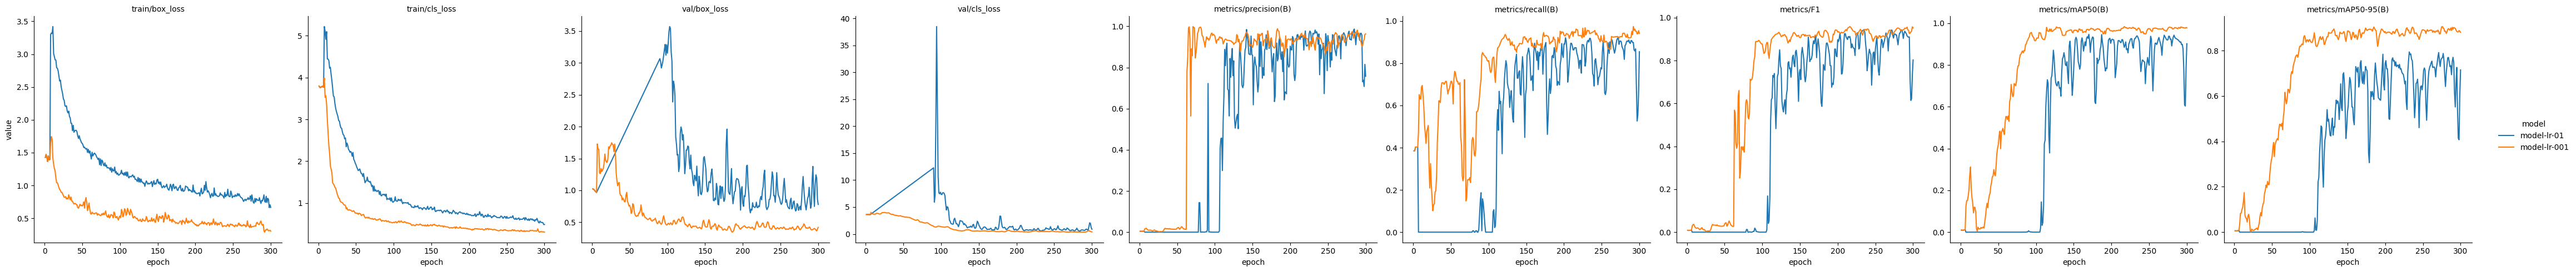

In [ ]:
g = sns.relplot(data=both_long,
                x='epoch', y='value',
                hue='model',
                col='metric',
                kind='line',
                facet_kws={'sharey': False})
g.set_titles(col_template='{col_name}')
plt.show()

# Выводы

Как видно из графиков выше и результатов тестирования, модель обученная с **lr=0.001** показала себя намного лучше. Сходимость на обучении быстрее и стабильнее, метрики качества на тестировании выше:
 * **lr=0.01**: mAP50-95 = 0.769 (test)
 * **lr=0.001**: mAP50-95 = 0.933 (test)

**lr=0.01** слишком большой для данной задачи поэтому мы как бы "перешагиваем" оптимальную область. Это видно на графиках: вначале обучения можно заметить "взрыв" лосса и уход метрик в 0. Затем градиенты всё таки уменьшились и обучение более менее стабилизировалось, но время было потеряно. Но если смотреть на графики, то оно всё ещё не такое стабильное как с **lr=0.001**

В случае **lr=0.001** мы видим стабильное уменьшение лосса с самого начала, что говорит о том, что 0.001 более оптимальный шаг для данной задачи.

Мы по сути отключили планировщик, поэтому в данном случае мы честно сравниваем learning rate. Однако скорее всего с включенным планировщиком результаты были бы лучше, а обучение стабильнее, но тогда было бы сложно провести честное сравнение.             

Более репрезентативные результаты тестирования можно получить увеличив выборку (снять блюда с разных ракурсов, в разной степени "съеденности", в разной обстановке). Таким образом мы бы получили более универсальную модель.

Сложности, с которыми столкнулась: изначально был выбран не очень удачный инструмент для аннотирования *labelImg*. Попробовав его, я поняла, что он не очень удобен для меня и остановилась на **Roboflow**.

Также во время сбора датасета, а именно удаления дубликатов, было сложно соблюсти баланс между слишком маленьким датасета, которого будет недостаточно для обучения, и датасетом с большим количеством дубликатов, что может повести за собой дата лик и завышенные результаты на тесте.

При сравнении разных значений **lr** сначала получала идентичные результаты, по причине трансформации **lr** под капотом. Честное сравнение удалось провести после фиксирования остальных параметров, влияющих на оптимизацию learning rate.

Кроме того, столкнулась с ограничениями Google Colab, для записи видео-детекции пришлось запускать отдельный скрипт тестирования локально на CPU.

# Скачивание архива с результатами

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('runs', 'zip', 'runs')
files.download('runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>